# **RNN을 이용한 텍스트 생성(Text Generation using RNN)**
다대일(many-to-one) 구조의 RNN을 사용해 문맥을 반영한 텍스트를 생성하는 RNN 언어모델을 만들어 보겠습니다. <br><br>
**Q1. 예제를 참고하여 모델에 훈련시킬 문장을 입력해봅시다. <br>
Q2. RNN 모델의 임베딩 벡터 차원과 은닉 상태의 크기에 적절한 값을 입력하여 모델의 정확도(accuracy)를 높이고, 손실(loss)를 줄여봅시다.** <br><br>
코드는 딥 러닝을 이용한 자연어 처리 입문(유원준) 교재에서 발췌하였습니다.

**텍스트 샘플** 

| 경마장에 있는 말이 뛰고 있다 <br>
| 그의 말이 법이다 <br>
| 가는 말이 고와야 오는 말이 곱다 <br>

모델이 전체 문장의 앞 단어들을 전부 고려하여 문맥을 학습할 수 있도록, 데이터를 재구성합니다.

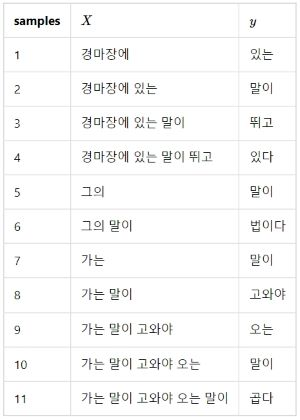

## **1. 데이터에 대한 이해와 전처리**

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

***아래 문장을 지우고 자신이 모델에 학습시킬 문장을 입력해주세요. 문장 개수는 꼭 3개가 아니어도 됩니다.***

In [2]:
text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [24]:
text = """간장 공장 공장장은 강 공장장이고\n 
된장 공장 공장장은 공 공장장이다.\n"""

In [26]:
# 단어집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합의 크기: %d' % vocab_size)

단어 집합의 크기: 9


In [27]:
# 단어와 단어에 부여된 정수 인덱스 출력
print(tokenizer.word_index)

{'공장': 1, '공장장은': 2, '간장': 3, '강': 4, '공장장이고': 5, '된장': 6, '공': 7, '공장장이다': 8}


## 2. 훈련 데이터 생성

In [28]:
sequences = list()

for line in text.split('\n'): # 줄바꿈 문자를 기준으로 문장 토큰화
  encoded = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(encoded)):
    sequence = encoded[:i+1]
    sequences.append(sequence)

print('학습을 위한 샘플 개수: %d' % len(sequences))

학습을 위한 샘플 개수: 8


In [29]:
# 전체 샘플 출력
# ex. [2,3]: [경마장에,있는], [2,3,1]: [경마장에,있는,말이]
# 맨 우측의 단어를 레이블로 분리함
print(sequences)

[[3, 1], [3, 1, 2], [3, 1, 2, 4], [3, 1, 2, 4, 5], [6, 1], [6, 1, 2], [6, 1, 2, 7], [6, 1, 2, 7, 8]]


In [30]:
# 패딩 진행: 샘플의 길이 일치시키기
max_len = max(len(l) for l in sequences) # 가장 길이가 긴 샘플 길이 출력
print('샘플 최대 길이: {}'.format(max_len))

샘플 최대 길이: 5


In [31]:
# 패딩 결과 확인
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences)

[[0 0 0 3 1]
 [0 0 3 1 2]
 [0 3 1 2 4]
 [3 1 2 4 5]
 [0 0 0 6 1]
 [0 0 6 1 2]
 [0 6 1 2 7]
 [6 1 2 7 8]]


In [32]:
# 라벨링 진행 
sequences = np.array(sequences)
X = sequences[:, :-1]
y = sequences[:, -1]

In [33]:
print(X)

[[0 0 0 3]
 [0 0 3 1]
 [0 3 1 2]
 [3 1 2 4]
 [0 0 0 6]
 [0 0 6 1]
 [0 6 1 2]
 [6 1 2 7]]


In [34]:
print(y)

[1 2 4 5 1 2 7 8]


In [35]:
# 원 핫 인코딩 진행
y = to_categorical(y, num_classes=vocab_size)
print(y)

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 3. RNN 모델
**모델 설명**: 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는, 다중 클래스 분류 문제를 수행하는 RNN 모델입니다. <br>
따라서 출력층에 소프트맥스 활성화 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. <br><br>
***아래의 ###을 지우고 임베딩 벡터 차원과 은닉 상태의 크기를 적절하게 입력해주세요.***

In [38]:
embedding_dim = 8
hidden_units = 8

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.2203 - accuracy: 0.0000e+00 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 2.2118 - accuracy: 0.0000e+00 - 8ms/epoch - 8ms/step
Epoch 3/200
1/1 - 0s - loss: 2.2035 - accuracy: 0.0000e+00 - 8ms/epoch - 8ms/step
Epoch 4/200
1/1 - 0s - loss: 2.1953 - accuracy: 0.0000e+00 - 12ms/epoch - 12ms/step
Epoch 5/200
1/1 - 0s - loss: 2.1873 - accuracy: 0.0000e+00 - 8ms/epoch - 8ms/step
Epoch 6/200
1/1 - 0s - loss: 2.1794 - accuracy: 0.1250 - 9ms/epoch - 9ms/step
Epoch 7/200
1/1 - 0s - loss: 2.1717 - accuracy: 0.1250 - 10ms/epoch - 10ms/step
Epoch 8/200
1/1 - 0s - loss: 2.1642 - accuracy: 0.1250 - 9ms/epoch - 9ms/step
Epoch 9/200
1/1 - 0s - loss: 2.1567 - accuracy: 0.1250 - 10ms/epoch - 10ms/step
Epoch 10/200
1/1 - 0s - loss: 2.1493 - accuracy: 0.2500 - 10ms/epoch - 10ms/step
Epoch 11/200
1/1 - 0s - loss: 2.1419 - accuracy: 0.2500 - 10ms/epoch - 10ms/step
Epoch 12/200
1/1 - 0s - loss: 2.1346 - accuracy: 0.2500 - 10ms/epoch - 10ms/step
Epoch 13/200
1/1 - 0s - loss: 2

***아래의 ###을 지우고 자신이 학습시킨 모델의 최종 정확도와 손실값을 입력해주세요.*** <br>
accuracy: 0.8750  <br>
loss: 0.5882

## 4. 모델 예측 결과 확인
입력된 단어로부터 다음 단어를 예측해 문장을 만들어 내는 함수 생성

In [39]:
def sentence_generation(model, tokenizer, current_word, n):
  init_word = current_word
  sentence = ''

  for _ in range(n):
    # 현재 단어에 대한 정수 인코딩과 패딩
    encoded = tokenizer.texts_to_sequences([current_word])[0]
    encoded = pad_sequences([encoded], maxlen=5, padding='pre')
    
    # 입력한 X(현재 단어)에 대해서 y를 예측하여 result에 저장.
    result = model.predict(encoded, verbose=0)
    result = np.argmax(result, axis=1)

    for word, index in tokenizer.word_index.items(): 
      # 예측한 단어와 인덱스와 동일한 단어가 있다면 break
      if index == result:
        break

    # 현재 단어 갱신: 현재 단어 + ' ' + 예측 단어
    current_word = current_word + ' '  + word
    
    # 예측 단어를 문장으로 저장
    sentence = sentence + ' ' + word

  sentence = init_word + sentence
  return sentence

***자신이 학습시킨 문장을 바탕으로 예측을 수행해주세요.***

In [42]:
# '경마장에 있는 말이 뛰고 있다' 문장 예측 시도 (뒤에 올 단어 개수만큼 반복)
print(sentence_generation(model, tokenizer, '간장', 5))

간장 공장 공장 강 공 공장장이다


In [43]:
print(sentence_generation(model, tokenizer, '간장', 2))
print(sentence_generation(model, tokenizer, '공장', 4))

간장 공장 공장
공장 공장 공장 공 공장장이다
